# Numpy-Based Implementation

In [2]:
import numpy as np
import random

In [33]:
from IPython.display import Image, display

In [3]:
# # NB: RUN ONLY ONCE!!
# datapath = "/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/DATA/neural-networks-and-deep-learning-master/"
# import sys
# sys.path.append(datapath)

In [4]:
class NNNumpy:
    
    def __init__(self, sizes): 
        # ARGS
        #  sizes: [2,3,1] = 2 neurons in input, 3 in hidden, 1 in output.
        self.numLayers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y,1) for y in sizes[1:]] 
            # generate bias=1 for each layer. the first layer (input) doesn't need bias.
            # e.g. each neuron in hidden gets a bias=1. 
            #  because each neuron processes a \sum_dot(W,t).
        self.weights = [np.random.randn(y,x) for x,y in zip(sizes[:-1],sizes[1:])]
            # the dimensions of the weight-matrix between layer s and t is t*s
            # e.g. [2,3,1] architecture, input(2) -- W1 -- hidden(3), W1 = 3x2.
            #  W1_jk is the connection between the kth in input and jth in hidden.
            # this is for the convenience of computation:
            #  input   W1   hidden
            #  2x1     3x2  3x1
            #  dim_hidden(3x1) = W1*input(3x2 * 2x1 = 3x1).
            #  otherwise, we would have to write (input^T*W1)^T.
        # correspondences:
        #  input    W1    hidden   W2    output
        #           ^       ^      ^       ^
        #           |       |      |       |
        #           |   biases[0]  |    biases[1]
        #           |              |
        #       weights[0]      weights[1]
     
    def forward_propagation(self, a):
        # ARGS
        #  a: input vector.
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
        # flow of propagation (e.g. [2,3,1] architecture):
        # 
        #  output = sigmoid(W2*sigmoid(W1*a + b1) + b2)
        # 
        #    b1(3x1)    W1(3x2)    a(2x1)
        #      W1*a + b1 = sigmoid((3x2 * 2x1) + 3x1) = 3x1 => a(3x1)
        #    b2(1x1)    W2(1x3)    a(3x1)
        #      W2*a + b2 = sigmoid((1x3 * 3x1) + 1x1) = 1x1 => a(1x1)
        #    a => output
    
    def SGD(self, X_train, epochs, batchSize, lr, test=None):
        # ARGS
        #  X_train: [(x1,y1),(x2,y2),..]
        #  epochs: the number of cycles.
        #  batchSize: the size stochastic gradient-sampling.
        #  lr: learning rate.
        #  test: if provided, evaluate learning against it after each epoch.
        # DEPS
        #  self.update_batch [single step of gradient descent]
        #  self.evaluate
        if test: nTest = len(test)
        n = len(X_train)
        for j in xrange(epochs):
            # xrange(start,end,[step]): same as range(), 
            # except it generates an immutable sequence,
            #  same amount of memory use no matter the size range represents.
            random.shuffle(X_train)
            batches = [ X_train[k:k+batchSize] for k in xrange(0, n, batchSize) ]
                # partitioning data into batches, each is of _batchSize_ size.
            for batch in batches:
                self.update_batch(batch, lr)
            if test:
                print "Epoch {0}: {1} / {2}".format(j, self.evaluate(test), nTest)
            else: 
                print "Epoch {0} complete".format(j)
    
    def update_batch(self, batch, lr):
        # ARGS
        #  batch: [(x1,y1),(x2,y2),..] sample from X_train.
        #  lr: passed from SGD.
        # DEPS
        #  self.back_propagation
        bGrads = [ np.zeros(b.shape) for b in self.biases ]
        wGrads = [ np.zeros(w.shape) for w in self.weights ]
            # create a zero list for each bias/weight matrix.
        for x, y in batch:
            # backprop data point by data point.
            bGradDeltas, wGradDeltas = self.back_propagation(x, y)
                # proper bias/weight gradient deltas are computed by backprop process.
            bGrads = [bGrad+bGradDelta for bGrad,bGradDelta in zip(bGrads,bGradDeltas)]
            wGrads = [wGrad+wGradDelta for wGrad,wGradDelta in zip(wGrads,wGradDeltas)]
                # put computed gradient deltas in zero containers.
        self.biases = [ b-(lr/len(batch))*bGrad for b,bGrad in zip(self.biases,bGrads) ]
        self.weights = [ w-(lr/len(batch))*wGrad for w,wGrad in zip(self.weights,wGrads) ]
            # update biases/weights after the whole batch is done.
            #  b_l <- b_l - lr/len(smp) * \sum dC_smp/db_l
            #  w_k <- w_k - lr/len(smp) * \sum dC_smp/dw_k
            #             ^                ^
            #             |                |
            #   computed after loop   computed in loop
    
    def back_propagation(self, x, y): # TODO: output = sigmoid(W2*sigmoid(W1*a + b1) + b2) 
        # ARGS
        #  x, y: a pair of data points.
        # DEPS
        #  self.cost_derivative
        #  sigmoid, sigmoid_prime
        bGrads = [ np.zeros(b.shape) for b in self.biases ]
        wGrads = [ np.zeros(w.shape) for w in self.weights ]
            # create a zero list for each bias/weight matrix.
        
        activation = x                                                      # forward step
        activations = [x] # list for sigmoid(W*a + b)                            #
        zs = [] # list for (W*a + b)                                             #
        for b,w in zip(self.biases, self.weights):                               #
            z = np.dot(w, activation) + b                                        #
            zs.append(z)                                                         #
            activation = sigmoid(z)                                              #
            activations.append(activation)                                       #
                                                                            # backward step
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) #
            # BP1: compute error delta^L at the output layer                     #
            #                                                                    #
            # delta_j^L = dC/dz_j^L                                              #
            #           = dC/da_j^L * da_j^L/dz_j^L                              #
            #                ^               ^                                   #
            #                |               |                                   #
            #   pace at which cost       pace at which                           #
            #   changes wrt. activation  activation changes                      #
            #                            wrt. pre-sigmoid output                 #
            #                                                                    #  
            # NB: the '*' multiplication here is Hadamard.                       #
            #                                                                    #
        bGrads[-1] = delta                                                       #
            # BP3: compute the rate of change of the cost wrt bias.              #
            #                                                                    #
            # dC/db_l = delta^l                                                  #
            #                                                                    #
        wGrads[-1] = np.dot(delta, activations[-2].transpose())                  #
        for l in xrange(2, self.numLayers):                                      #
            z = zs[-l]                                                           #
            sp = sigmoid_prime(z)                                                #
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp           #
            # BP2: compute error delta^l at a non-output layer                   #
            #                                                                    #
            # delta^l = ( (w^l+1)^T %*% delta^l+1 ) * sigma'(z^l) (i.e. dC/da_l) #
            #                        ^                    ^                      #
            #                        |                    |                      #
            #            error propagated back       pace at which               #
            #            from layer l+1              activation (at layer l)     #
            #                                        changes wrt. z^l            #
            #                                                                    #
            # e.g. 2(l=1) -> 3(l=2) -> 1(l=3) architecture, at layer l=2         # 
            #      the number of local neurons = 3                               #
            #      the size of the matrix between l=2 and l=3 is 1x3             #
            #      ( (w^l+1)^T %*% delta^l+1 ) = ( (1x3)^T %*% 1x1 ) => 3x1      #
            #      sigma'(z^l) = 3x1                                             #
            #                                                                    #
            bGrads[-l] = delta                                                   # 
            wGrads[-l] = np.dot(delta, activations[-l-1].transpose())            #
            # BP4: compute the rate of change of the cost wrt. weight            #
            #                                                                    #
            # dC/dw_jk^l = a_k^l-1 %*% delta_j^l                                 #
            #                                                                    #
            # e.g. 2(l=1) -> 3(l=2) -> 1(l=3) architecture, at layer l=3         #
            #      activation at layer l-1 (i.e. l=2) is 3x1                     #
            #      error delta^l is 1x1                                          #
            #      delta^l %*% a^l-1 = 1x1 %*% (3x1)^T => 1x3 (dim of w^l)       #
            #                                                                    #
        return (bGrads, wGrads)                                                  #
            # overall updates                                                    #
            # e.g. 2(l=1) -> 3(l=2) -> 1(l=3) architecture, at layer l=2         #
            #                                                                    #
            #       l=1               l=2                l=3                     #
            #     #######           ########          ########                   #
            #     #input#   w=2-----#hidden#    w=3---#output#                   #
            #     #######           ########     ^    ########                   #
            #                       b=1  delta^2 |    b=2  delta^3               #
            #                       ^      ^     |    ^      ^                   #
            #                       |      |     |    |      |                   #
            #                       BP3   BP2   BP4  BP3    BP1                  #
            #                                                                    #
            # NB: for BPs, see figure attached after this cell.                  #
    
    def evaluate(self, test):
        # ARGS
        #  test: testset, for which return the number of corrected predicted.
        # DEPS
        #  self.forward_propagation
        testResults = [ (np.argmax(self.forward_propagation(x)), y) for (x, y) in test ]
        return sum(int(x==y) for (x,y) in testResults)
    
    def cost_derivative(self, outputActivations, y):
        # ARGS
        #  outputActivations: output.
        #  y: correct.
        return (outputActivations-y)
            # dC/da (note: a = output)
            # why a - y?
            #  C = 1/2 \sum_j (y_j - a_j)^2
            #  dC/da = (a_j - y_j)

BACKPROP EQUATIONS:


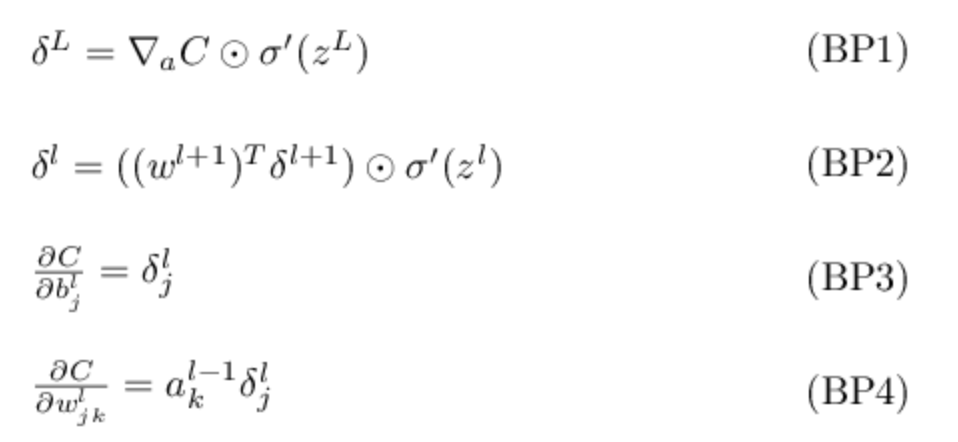

BACKPROP ALGORITHM:


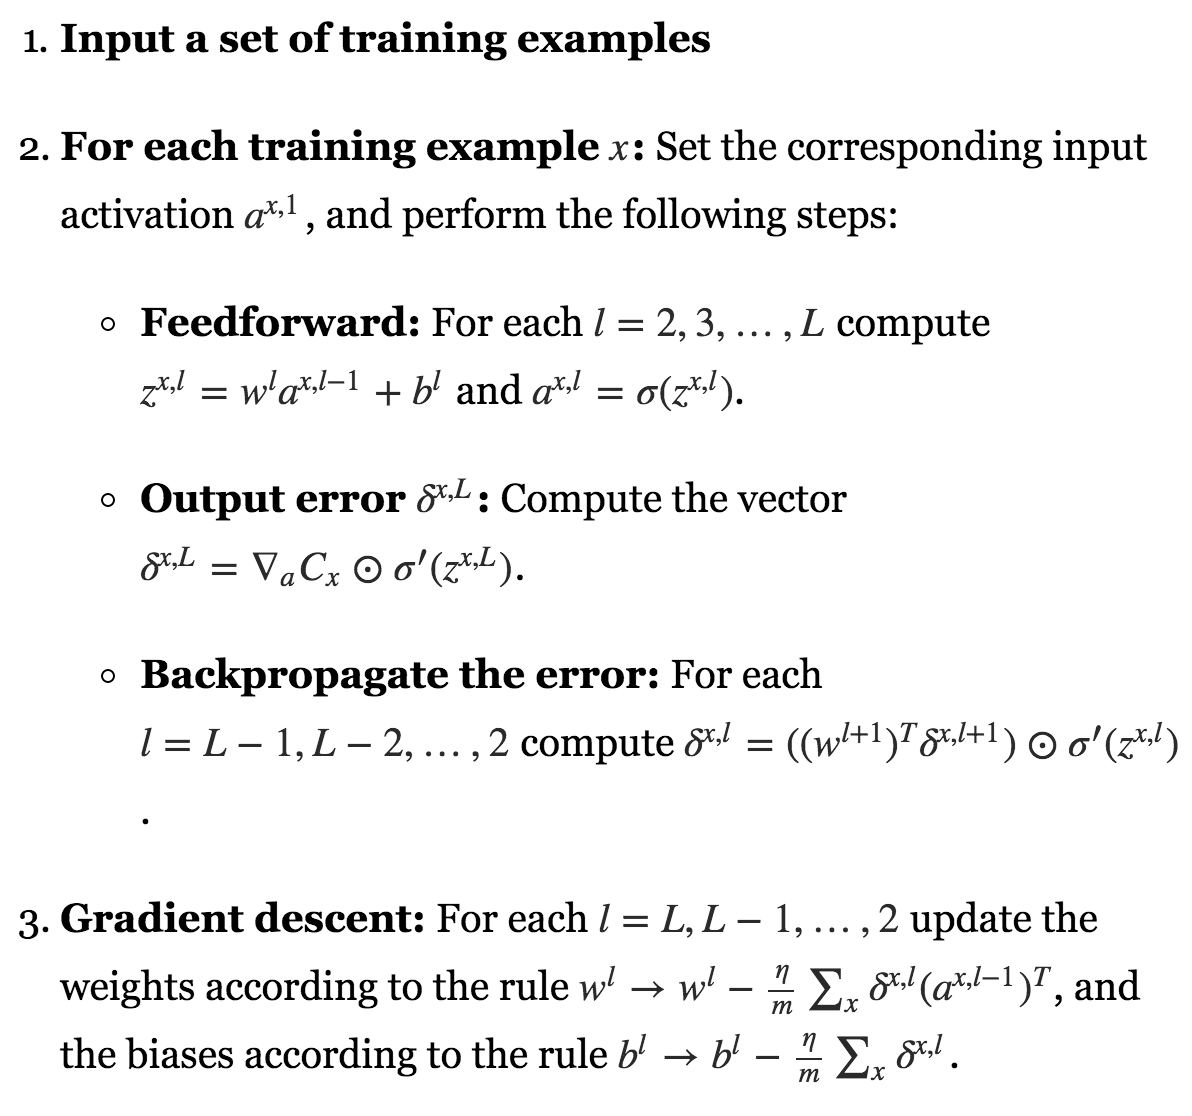

In [37]:
# BPS
print "BACKPROP EQUATIONS:"
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/backprop_equations.png", width="35%"))
print "BACKPROP ALGORITHM:"
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/backprop_algorithm.png", width="40%"))

In [93]:
def sigmoid(z):
    return 1.0 / (1.0+np.exp(-z)) # np.exp() applies elementwise if z is a vector.
def sigmoid_prime(z): # derivative of sigmoid.
    return sigmoid(z) * (1-sigmoid(z))

In [4]:
np.random.randn(2,1)

array([[-0.07564007],
       [ 1.5933445 ]])

In [9]:
sizes = [2,3,1]
sizes[:-1]

[2, 3]

In [10]:
biases = [np.random.randn(y,1) for y in sizes[1:]]
weights = [np.random.randn(y,x) for x,y in zip(sizes[:-1],sizes[1:])]

In [12]:
for b,w in zip(biases,weights):
    print "##"
    print np.array(b).shape
    print np.array(w).shape
    print "##"

##
(3, 1)
(3, 2)
##
##
(1, 1)
(1, 3)
##


In [24]:
biases[1]
weights[1]

array([[ 1.23623962,  1.23493466, -1.13736183]])

In [17]:
weights[-1].transpose()

array([[-0.68550867],
       [-1.04460832],
       [ 1.03628779]])

In [21]:
np.dot(weights[-1].transpose(), np.array([1,1,1]).reshape(1,3))

array([[-0.68550867, -0.68550867, -0.68550867],
       [-1.04460832, -1.04460832, -1.04460832],
       [ 1.03628779,  1.03628779,  1.03628779]])

In [94]:
import mnist_loader # works when under '~/src' path.
X_train, X_dev, X_test = mnist_loader.load_data_wrapper()

In [95]:
fnn = NNNumpy([784,30,10])

In [96]:
fnn.SGD(X_train,30,10,3.0,test=X_test)

Epoch 0: 9097 / 10000
Epoch 1: 9248 / 10000
Epoch 2: 9217 / 10000
Epoch 3: 9293 / 10000
Epoch 4: 9357 / 10000
Epoch 5: 9373 / 10000
Epoch 6: 9390 / 10000
Epoch 7: 9383 / 10000
Epoch 8: 9386 / 10000
Epoch 9: 9428 / 10000
Epoch 10: 9430 / 10000
Epoch 11: 9442 / 10000
Epoch 12: 9458 / 10000
Epoch 13: 9459 / 10000
Epoch 14: 9459 / 10000
Epoch 15: 9476 / 10000
Epoch 16: 9459 / 10000
Epoch 17: 9470 / 10000
Epoch 18: 9487 / 10000
Epoch 19: 9473 / 10000
Epoch 20: 9457 / 10000
Epoch 21: 9489 / 10000
Epoch 22: 9472 / 10000
Epoch 23: 9485 / 10000
Epoch 24: 9476 / 10000
Epoch 25: 9510 / 10000
Epoch 26: 9475 / 10000
Epoch 27: 9478 / 10000
Epoch 28: 9505 / 10000
Epoch 29: 9489 / 10000
